# **Fraud detection**

### Introduction

This project focuses on building a fraud detection system using real-world financial transaction data. The main objective is to identify potentially fraudulent transactions by analyzing patterns in key features such as transaction type, amount, and account balances. Given the extreme class imbalance—where fraudulent cases represent a tiny fraction of all transactions—special attention is paid to handling imbalanced data, evaluating models with appropriate metrics (precision, recall, PR AUC), and developing a strategy for threshold tuning. In addition to traditional classification models like logistic regression and random forest, time series analysis is also explored to better understand temporal patterns in fraudulent activity. The final output is an interactive Streamlit app that allows users to input transaction details and receive real-time fraud predictions.

Dataset source: https://www.kaggle.com/datasets/amanalisiddiqui/fraud-detection-dataset/data

### Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [320]:
df = pd.read_csv("AIML Dataset.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Data exploration and description

In [9]:
df.shape

(6362620, 11)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [338]:
df.describe().T.astype(int)

,count,mean,std,min,25%,50%,75%,max
step,6362620,243,142,1,156,239,335,743
amount,6362620,179861,603858,0,13389,74871,208721,92445516
oldbalanceOrg,6362620,833883,2888242,0,0,14208,107315,59585040
newbalanceOrig,6362620,855113,2924048,0,0,0,144258,49585040
oldbalanceDest,6362620,1100701,3399180,0,0,132705,943036,356015889
newbalanceDest,6362620,1224996,3674128,0,0,214661,1111909,356179278
isFraud,6362620,0,0,0,0,0,0,1
isFlaggedFraud,6362620,0,0,0,0,0,0,1


In [15]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [17]:
df['isFraud'].value_counts(1) * 100

isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64

In [19]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

### Missing values

In [21]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## **Time series analysis - 'step' variable**

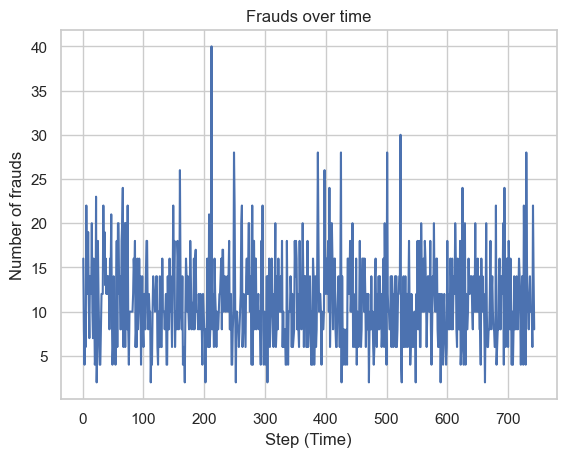

In [324]:
# Number of frauds by unit of time
frauds_per_step = df[df['isFraud'] == 1]['step'].value_counts().sort_index()
plt.plot(frauds_per_step.index, frauds_per_step.values, label = 'Frauds per step')
plt.xlabel('Step (Time)')  # I'm not sure about this
plt.ylabel("Number of frauds")
plt.title("Frauds over time")
plt.grid(True)
plt.show();

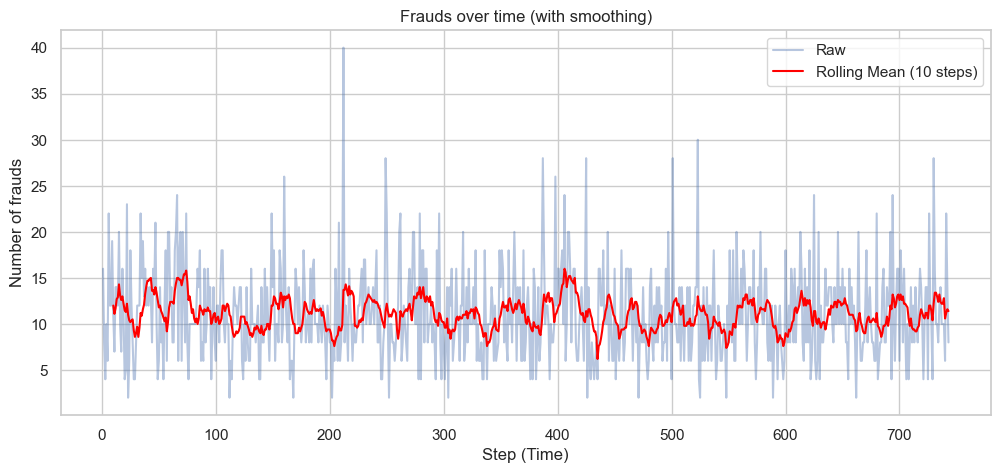

In [432]:
# Smooth the line with a rolling window
rolling_fraud = frauds_per_step.rolling(window=10).mean()

plt.figure(figsize=(12, 5))
plt.plot(frauds_per_step.index, frauds_per_step.values, alpha=0.4, label='Raw')
plt.plot(rolling_fraud.index, rolling_fraud.values, color='red', label='Rolling Mean (10 steps)')
plt.xlabel('Step (Time)')
plt.ylabel('Number of frauds')
plt.title('Frauds over time (with smoothing)')
plt.legend()
plt.grid(True)
plt.show()

**Observations**

A priori, there's no trend regarding the number of frauds over time.

Let's dive deeper in the analysis. 

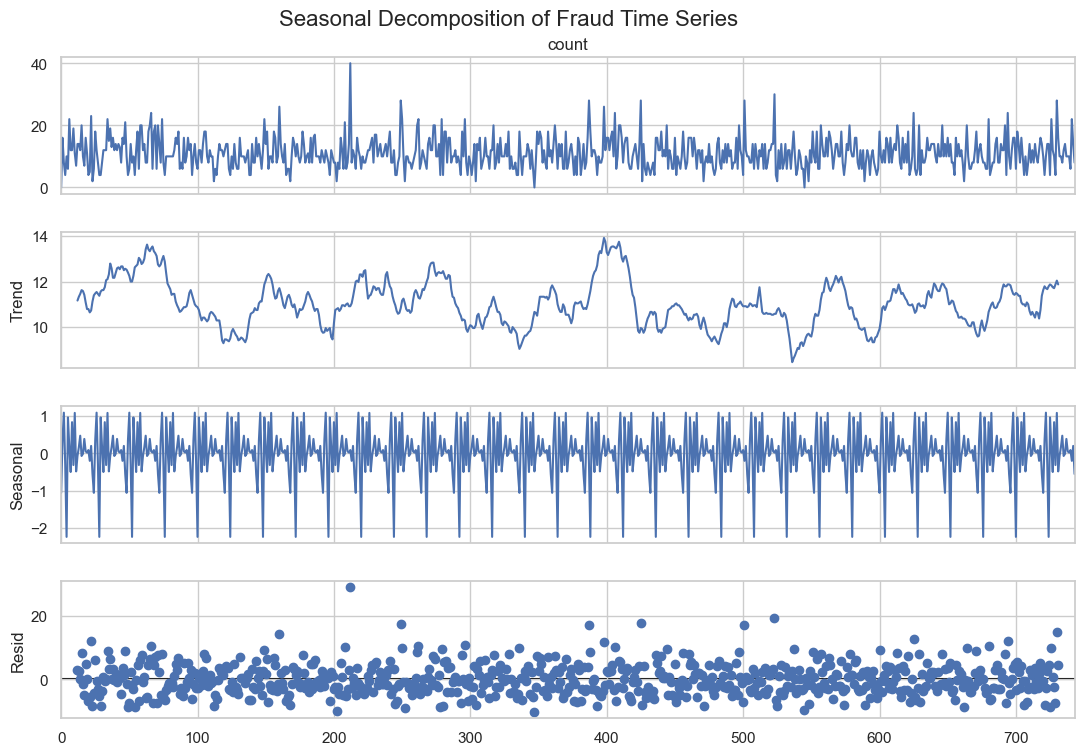

In [360]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Transform itno time series
frauds_ts = frauds_per_step.reindex(range(df['step'].max() + 1), fill_value=0)

# Make sure the index is treated as time
frauds_ts.index = pd.Index(frauds_ts.index)

# Decompose
decomposition = seasonal_decompose(frauds_ts, model='additive', period=24)

# Plot results
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Seasonal Decomposition of Fraud Time Series", fontsize=16)
plt.show()

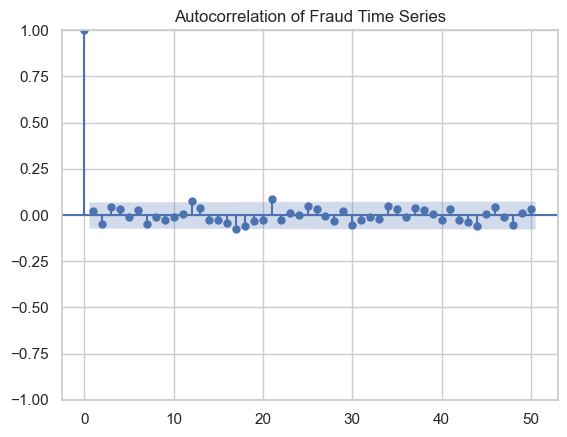

In [362]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(frauds_ts, lags=50)
plt.title("Autocorrelation of Fraud Time Series")
plt.show()

### **Observations:**

The analysis of the fraud time series reveals a generally stable trend with moderate fluctuations over time. The trend component oscillates between 10 and 13 frauds per time unit, without a clear upward or downward pattern, suggesting that fraudulent activity remains relatively constant. The seasonal component exhibits a strong and regular pattern, indicating that frauds tend to occur more frequently at specific intervals—likely related to user behavior cycles or strategically chosen times by fraudsters. The residuals are mostly centered around zero, with a few outliers that may correspond to unexpected spikes in fraud. Finally, the autocorrelation plot shows no significant correlation across time lags, implying that the number of frauds at a given time step is not dependent on past observations. These findings highlight a regular but non-autocorrelated fraud pattern, which can inform the choice of future modeling strategies.

In the seasonal decomposition of the fraud time series, we chose a period of 24 under the assumption that each time step represents an hourly unit, implying a full cycle every 24 steps—similar to a daily pattern. This choice allows us to investigate whether fraudulent transactions exhibit cyclical behavior within a day, which could be linked to operational schedules, user behavior, or system routines. Although no strong periodicity was confirmed by the autocorrelation plot, using period=24 provides a starting point to capture potential short-term seasonal effects that may not be immediately visible but still impact the data subtly.

In [365]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(frauds_per_step)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -26.747960167241164
p-value: 0.0


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5805.480, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4922.410, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5394.302, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4783.422, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4683.678, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=4635.146, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=4614.626, Time=0.04 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=4488.617, Time=0.09 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4486.679, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4485.354, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4484.535, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4484.6

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


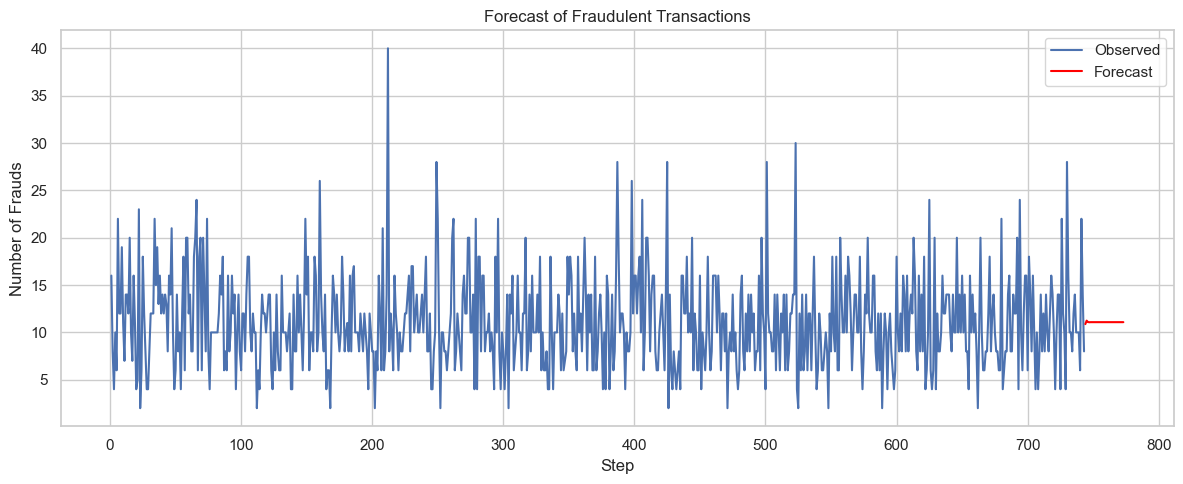

In [371]:
from pmdarima import auto_arima

# time series modeling - auto-arima
model = auto_arima(frauds_per_step, seasonal=False, d=0, trace=True, stepwise=True)

# Fit the model
model.fit(frauds_per_step)

# Forecast next 30 steps
n_periods = 30
forecast = model.predict(n_periods=n_periods)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(frauds_per_step.index, frauds_per_step.values, label='Observed')
future_index = range(frauds_per_step.index[-1] + 1, frauds_per_step.index[-1] + 1 + n_periods)
plt.plot(future_index, forecast, label='Forecast', color='red')
plt.title('Forecast of Fraudulent Transactions')
plt.xlabel('Step')
plt.ylabel('Number of Frauds')
plt.legend()
plt.tight_layout()
plt.show()

In [391]:
print(forecast)

741    10.877804
742    11.242833
743    11.097172
744    11.075461
745    11.082779
746    11.084048
747    11.083683
748    11.083610
749    11.083628
750    11.083632
751    11.083631
752    11.083631
753    11.083631
754    11.083631
755    11.083631
756    11.083631
757    11.083631
758    11.083631
759    11.083631
760    11.083631
761    11.083631
762    11.083631
763    11.083631
764    11.083631
765    11.083631
766    11.083631
767    11.083631
768    11.083631
769    11.083631
770    11.083631
dtype: float64


### Time series analysis - Conclusion

The time series analysis of fraudulent transactions provided valuable insights into their temporal dynamics. Although fraud incidents appear to occur somewhat randomly, the seasonal decomposition revealed a recurring cyclical component and an overall stable trend over time.

The autocorrelation analysis confirmed the absence of significant time-based dependencies between periods, suggesting the series behaves in a quasi-stationary manner. This was further supported by the Augmented Dickey-Fuller (ADF) test, which indicated that the series is statistically stationary.

An ARIMA model was implemented to forecast the short-term evolution of fraudulent activities. The selected model, ARIMA(2,0,0), produced a relatively constant forecast of around 11 fraud cases per time unit, highlighting the low volatility of the phenomenon. This stability may reflect consistent fraud behavior or detection mechanisms across the observed period.

While the predictive power of the model is inherently limited by the low variability, this approach remains useful for anticipating expected volumes and could support real-time fraud monitoring systems. For more complex temporal patterns, advanced models such as LSTM neural networks could be explored in future work.


### Model evaluation

In [451]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 90% train, 10% test
train_size = int(len(frauds_ts) * 0.9)
train, test = frauds_ts[:train_size], frauds_ts[train_size:]

# ajustment
model = ARIMA(train, order=(2,0,0))
model_fit = model.fit()

# forecast
forecast = model_fit.forecast(steps=len(test))

# MAE : Mean Absolute Error
mae = mean_absolute_error(test, forecast)

# RMSE : Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(test, forecast))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 3.9335919187369797
RMSE: 5.03139644791753


## Univariate analysis

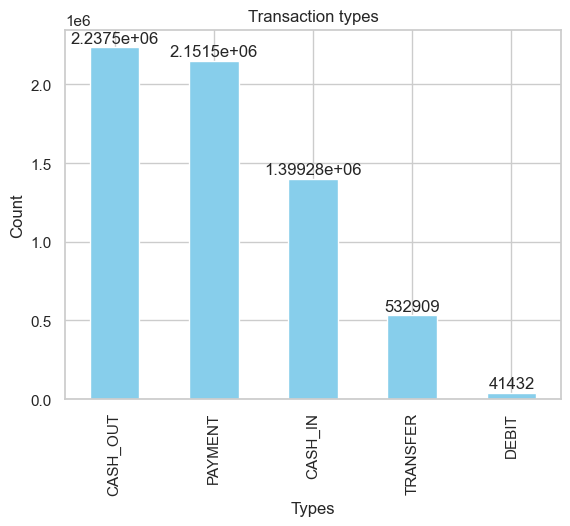

In [417]:
ax = df['type'].value_counts().plot(kind = 'bar', title = 'Transaction types', color = 'skyblue')
for container in ax.containers:
    ax.bar_label(container, padding = 1)
    
plt.xlabel('Types')
plt.ylabel('Count')
plt.show();

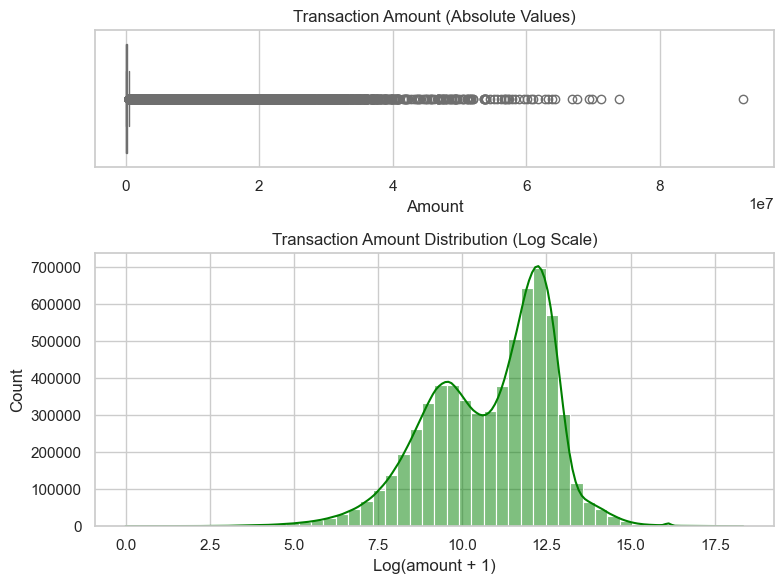

In [454]:
# Set up the figure with two rows
fig, axes = plt.subplots(2, 1, figsize=(8, 6), height_ratios=[1, 2])

# Top: Horizontal boxplot with raw values
sns.boxplot(x=df['amount'], ax=axes[0], orient='h', color='skyblue')
axes[0].set_title('Transaction Amount (Absolute Values)')
axes[0].set_xlabel('Amount')

# Bottom: Histogram with log-transformed values
sns.histplot(np.log1p(df['amount']), bins=50, kde=True, color='green', ax=axes[1])
axes[1].set_title('Transaction Amount Distribution (Log Scale)')
axes[1].set_xlabel('Log(amount + 1)')
axes[1].set_ylabel('Count')

# Improve layout
plt.tight_layout()
plt.show()

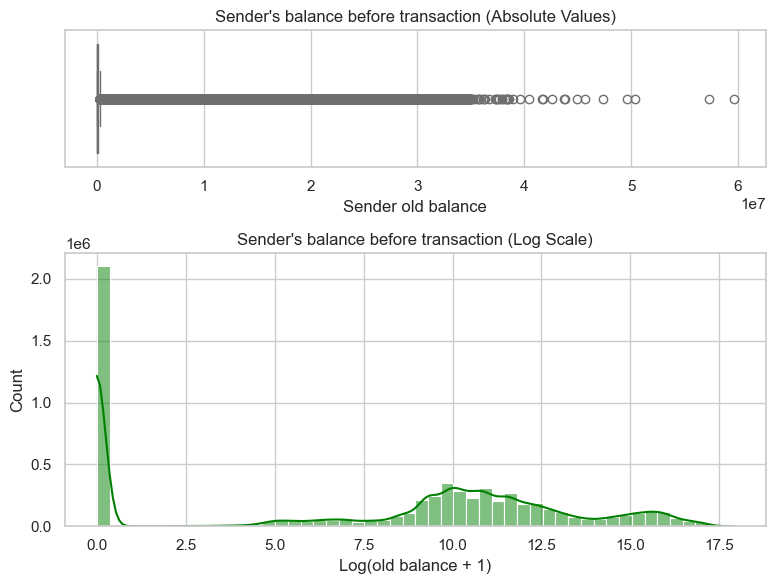

In [456]:
# oldbalanceOrg
# Set up the figure with two rows
fig, axes = plt.subplots(2, 1, figsize=(8, 6), height_ratios=[1, 2])

# Top: Horizontal boxplot with raw values
sns.boxplot(x=df['oldbalanceOrg'], ax=axes[0], orient='h', color='skyblue')
axes[0].set_title("Sender's balance before transaction (Absolute Values)")
axes[0].set_xlabel('Sender old balance')

# Bottom: Histogram with log-transformed values
sns.histplot(np.log1p(df['oldbalanceOrg']), bins=50, kde=True, color='green', ax=axes[1])
axes[1].set_title("Sender's balance before transaction (Log Scale)")
axes[1].set_xlabel('Log(old balance + 1)')
axes[1].set_ylabel('Count')

# Improve layout
plt.tight_layout()
plt.show()

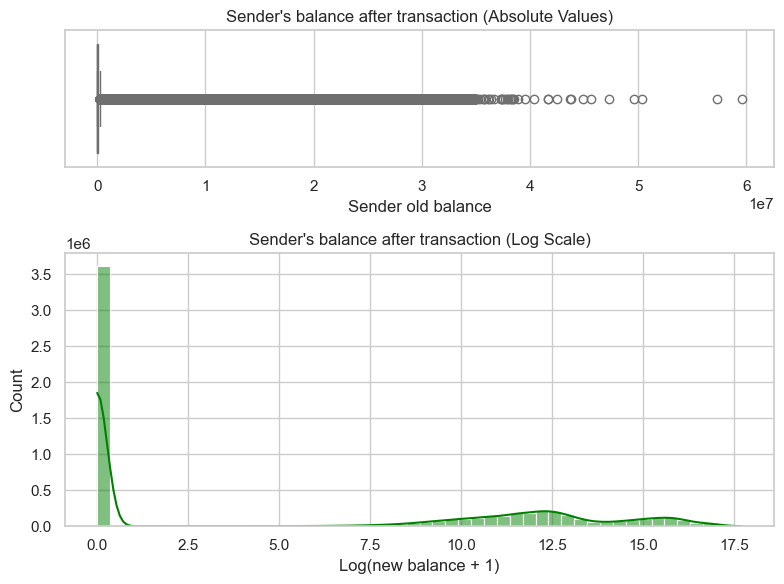

In [464]:
# newbalanceOrig
# Set up the figure with two rows
fig, axes = plt.subplots(2, 1, figsize=(8, 6), height_ratios=[1, 2])

# Top: Horizontal boxplot with raw values
sns.boxplot(x=df['oldbalanceOrg'], ax=axes[0], orient='h', color='skyblue')
axes[0].set_title("Sender's balance after transaction (Absolute Values)")
axes[0].set_xlabel('Sender old balance')

# Bottom: Histogram with log-transformed values
sns.histplot(np.log1p(df['newbalanceOrig']), bins=50, kde=True, color='green', ax=axes[1])
axes[1].set_title("Sender's balance after transaction (Log Scale)")
axes[1].set_xlabel('Log(new balance + 1)')
axes[1].set_ylabel('Count')

# Improve layout
plt.tight_layout()
plt.show()

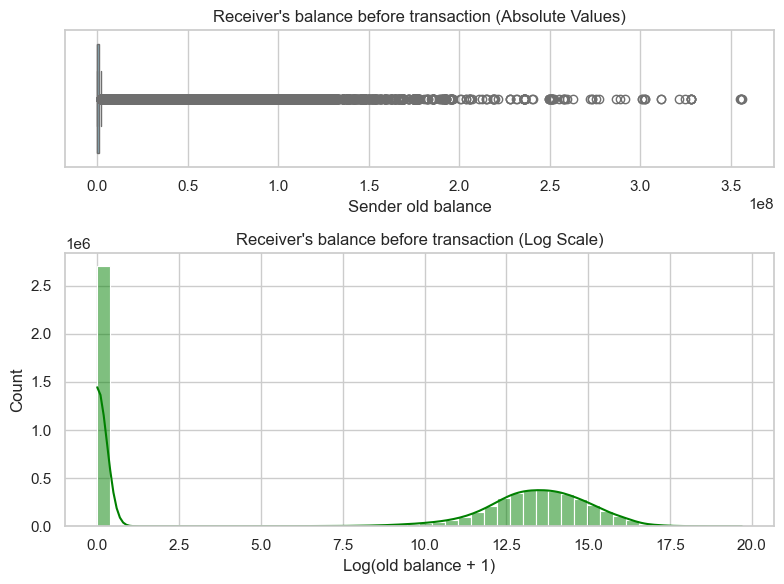

In [460]:
# oldbalanceDest
# Set up the figure with two rows
fig, axes = plt.subplots(2, 1, figsize=(8, 6), height_ratios=[1, 2])

# Top: Horizontal boxplot with raw values
sns.boxplot(x=df['oldbalanceDest'], ax=axes[0], orient='h', color='skyblue')
axes[0].set_title("Receiver's balance before transaction (Absolute Values)")
axes[0].set_xlabel('Sender old balance')

# Bottom: Histogram with log-transformed values
sns.histplot(np.log1p(df['oldbalanceDest']), bins=50, kde=True, color='green', ax=axes[1])
axes[1].set_title("Receiver's balance before transaction (Log Scale)")
axes[1].set_xlabel('Log(old balance + 1)')
axes[1].set_ylabel('Count')

# Improve layout
plt.tight_layout()
plt.show()

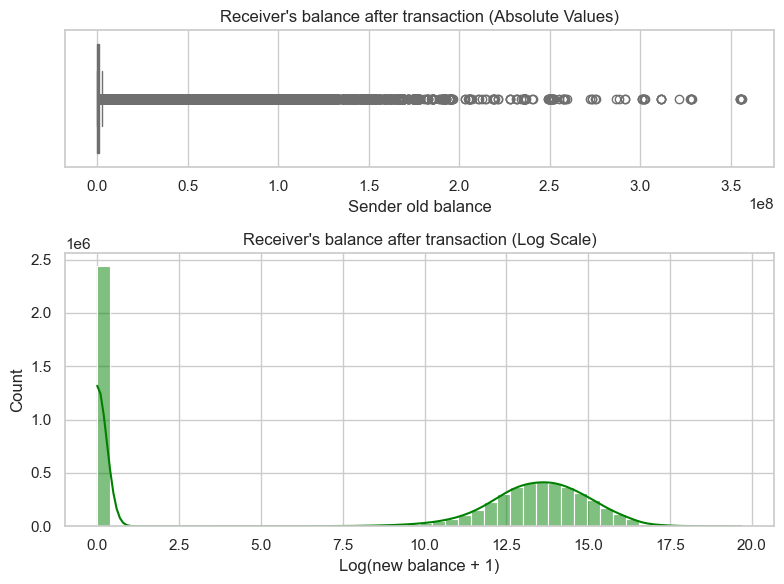

In [466]:
# newbalanceDest
# Set up the figure with two rows
fig, axes = plt.subplots(2, 1, figsize=(8, 6), height_ratios=[1, 2])

# Top: Horizontal boxplot with raw values
sns.boxplot(x=df['newbalanceDest'], ax=axes[0], orient='h', color='skyblue')
axes[0].set_title("Receiver's balance after transaction (Absolute Values)")
axes[0].set_xlabel('Sender old balance')

# Bottom: Histogram with log-transformed values
sns.histplot(np.log1p(df['newbalanceDest']), bins=50, kde=True, color='green', ax=axes[1])
axes[1].set_title("Receiver's balance after transaction (Log Scale)")
axes[1].set_xlabel('Log(new balance + 1)')
axes[1].set_ylabel('Count')

# Improve layout
plt.tight_layout()
plt.show()

### **Observations:**

Presence of outliers. Will need special treatment for some models.

### Normality test

In [425]:
from scipy.stats import kstest
from sklearn.preprocessing import StandardScaler

# Numerical columns
numerical_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Standardize the numerical variables
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numerical_columns])

# Convert to DataFrame for easy access
scaled_df = pd.DataFrame(scaled_data, columns=numerical_columns)

# Perform K-S test for each column
for col in numerical_columns:
    stat, p_value = kstest(scaled_df[col], 'norm')  # compare with standard normal
    print(f"{col}: KS-stat = {stat:.4f}, p-value = {p_value:.4f}")

amount: KS-stat = 0.3829, p-value = 0.0000
oldbalanceOrg: KS-stat = 0.4099, p-value = 0.0000
newbalanceOrig: KS-stat = 0.4057, p-value = 0.0000
oldbalanceDest: KS-stat = 0.3730, p-value = 0.0000
newbalanceDest: KS-stat = 0.3694, p-value = 0.0000


### **Observations:**

P-value < 0.05 ==> Reject H0: The variables do not follow a normal distribution. RobustScaler will then be used to standardize the input for some models.

## Bivariate analysis - Categorical

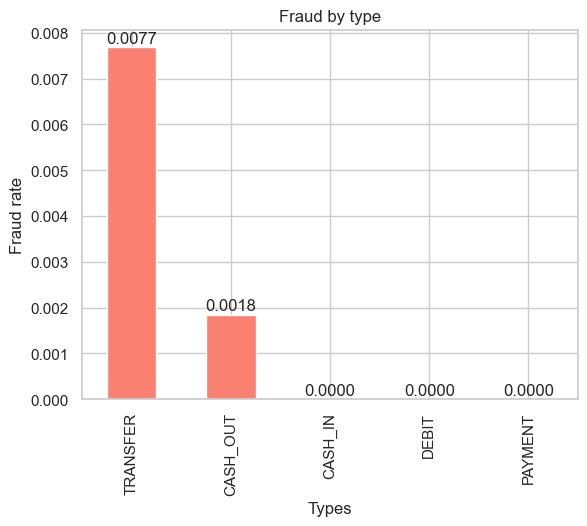

In [218]:
fraud_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
ax = fraud_by_type.plot(kind = 'bar', title = 'Fraud by type', color = 'salmon')

for container in ax.containers:
    ax.bar_label(container, fmt = '%.4f', padding=1)
    
plt.xlabel('Types')
plt.ylabel('Fraud rate')
plt.show();

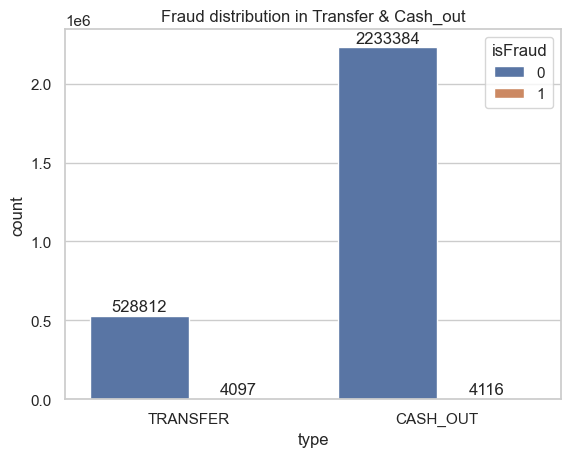

In [224]:
# Fraud types
fraud_types = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]

ax = sns.countplot(data=fraud_types, x='type', hue='isFraud')

for container in ax.containers:
    ax.bar_label(container, fmt = '%.0f', padding = 1)
    
plt.title('Fraud distribution in Transfer & Cash_out')
plt.show();

In [222]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['type'], df['isFraud'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi2 statistic:", chi2)
print("Degrees of freedom:", dof)
print("p-value:", p)

Chi2 statistic: 22082.53571319108
Degrees of freedom: 4
p-value: 0.0


### **Observations:**

P-value < 0.05 ==> Statistically significant relationship between a fraudulent transaction and its type.

## Bivariate analysis - Numerical

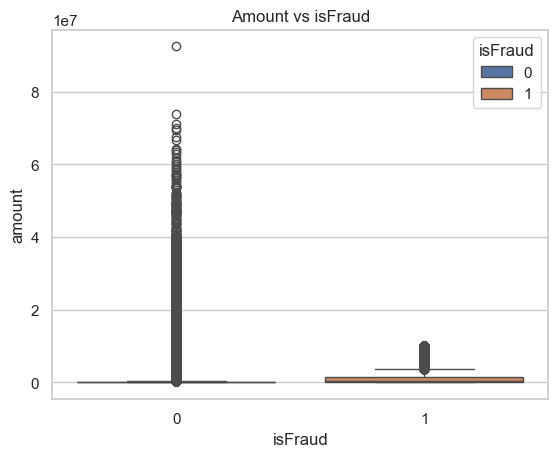

In [261]:
# Amount vs isFraud
sns.boxplot(df, y = 'amount', x = 'isFraud', hue = 'isFraud')
plt.title('Amount vs isFraud')
plt.show();

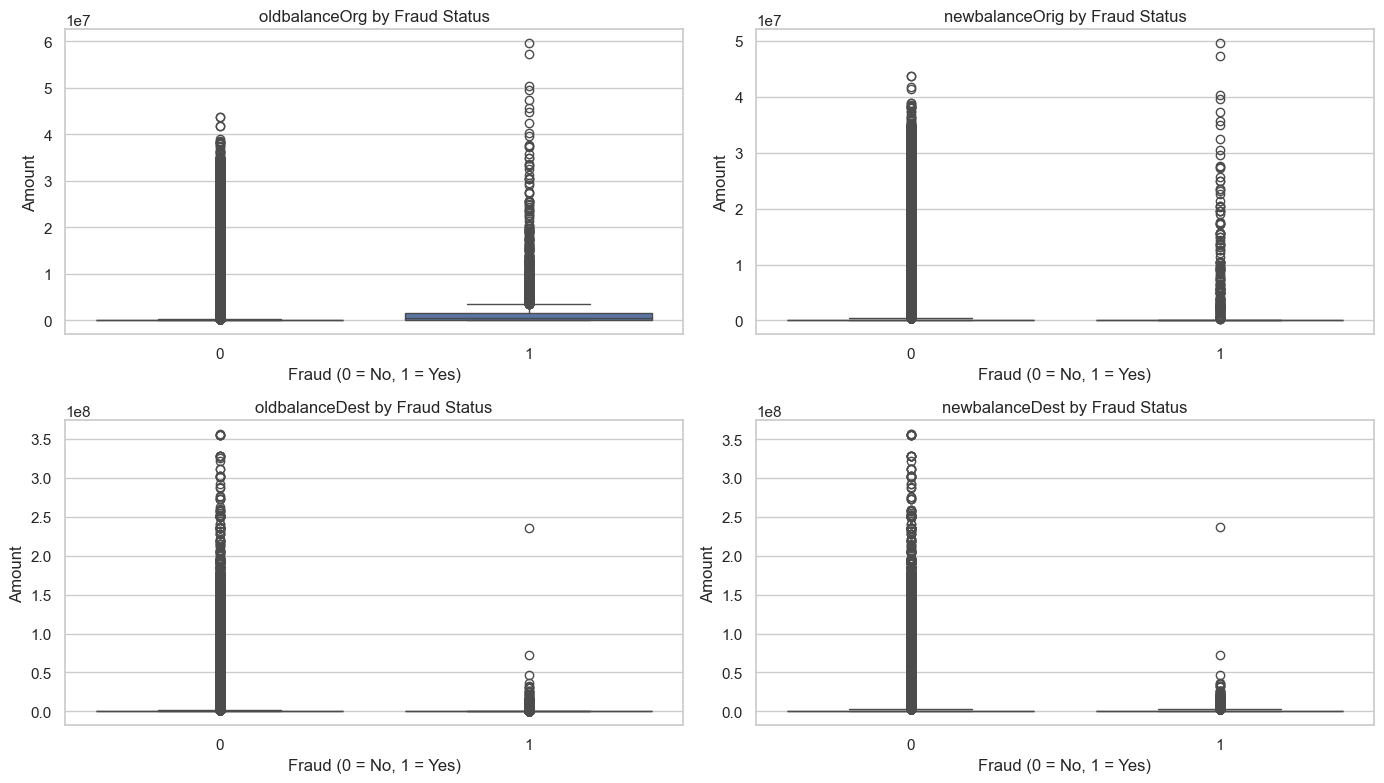

In [470]:
# Set plot style
sns.set(style="whitegrid")

# List of balance variables
balance_vars = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Create subplots: 2 rows x 2 columns
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

# Loop through the balance variables and create a boxplot for each
for i, var in enumerate(balance_vars):
    sns.boxplot(x='isFraud', y=var, data=df, ax=axes[i])
    axes[i].set_title(f'{var} by Fraud Status')
    axes[i].set_xlabel('Fraud (0 = No, 1 = Yes)')
    axes[i].set_ylabel('Amount')

plt.tight_layout()
plt.show()

### Kruskal-Wallis test - Median group comparison

In [335]:
from scipy.stats import kruskal

for var in numerical_columns:
    group0 = df[df['isFraud'] == 0][var]
    group1 = df[df['isFraud'] == 1][var]
    
    stat, p = kruskal(group0, group1)
    
    print(f"Kruskal-Wallis test for {var}:")
    print(f"  Statistic = {stat:.4f}, p-value = {p:.4e}")
    if p < 0.05:
        print("  ➤ Significant difference between fraud and non-fraud groups.\n")
    else:
        print("  ➤ No significant difference between fraud and non-fraud groups.\n")

Kruskal-Wallis test for amount:
  Statistic = 8273.3654, p-value = 0.0000e+00
  ➤ Significant difference between fraud and non-fraud groups.

Kruskal-Wallis test for oldbalanceOrg:
  Statistic = 9892.1695, p-value = 0.0000e+00
  ➤ Significant difference between fraud and non-fraud groups.

Kruskal-Wallis test for newbalanceOrig:
  Statistic = 4999.3782, p-value = 0.0000e+00
  ➤ Significant difference between fraud and non-fraud groups.

Kruskal-Wallis test for oldbalanceDest:
  Statistic = 1869.4554, p-value = 0.0000e+00
  ➤ Significant difference between fraud and non-fraud groups.

Kruskal-Wallis test for newbalanceDest:
  Statistic = 170.8410, p-value = 4.8471e-39
  ➤ Significant difference between fraud and non-fraud groups.



### Correlation analysis

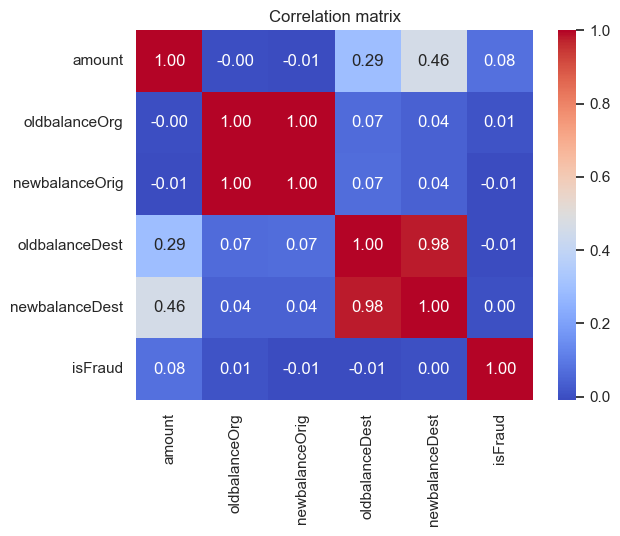

In [249]:
corr = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation matrix")
plt.show();

### **Observations:**

Several features showed strong pairwise correlations, which could introduce multicollinearity and impact the stability or interpretability of some models. To mitigate multicollinearity in the model (logistic regression), regularization (L1 or L2) will be applied. This penalizes redundant information and helps stabilize the model. However, tree-based models are generally robust to multicollinearity, as they do not rely on coefficients in the same way as linear models.

### Additional analysis

In [35]:
# Difference between the balance before and after the transaction - consistency verification with the amount
df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [37]:
(df['balanceDiffOrig'] < 0).sum()

1399253

In [39]:
(df['balanceDiffDest'] < 0).sum()

1238864

### Senders - analysis

In [46]:
top_senders = df['nameOrig'].value_counts().head(10)
top_senders

nameOrig
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
C1677795071    3
C1462946854    3
C1999539787    3
C2098525306    3
C400299098     3
Name: count, dtype: int64

### Receivers - analysis

In [48]:
top_receivers = df['nameDest'].value_counts().head(10)
top_receivers

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
Name: count, dtype: int64

In [50]:
fraud_users = df[df['isFraud'] == 1]['nameOrig'].value_counts().head(10)
fraud_users

nameOrig
C1305486145    1
C755286039     1
C973279667     1
C258213312     1
C1640703547    1
C1127265876    1
C317779855     1
C1064034527    1
C1141104763    1
C1966863341    1
Name: count, dtype: int64

### Accounts that went to 0 after transaction

In [67]:
zero_after_transfer = df[
    (df['oldbalanceOrg'] > 0) &
    (df['newbalanceOrig'] == 0) &
    (df['type'].isin(['TRANSFER', 'CASH_OUT']))
]

zero_after_transfer.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
2,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,181.0,0.00
3,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,181.0,-21182.00
15,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,15325.0,46430.44
19,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,705.0,-22425.00
24,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,10835.0,2712905.89


# **Modeling**

We're dropping variables that won't be included in the modeling part.

In [435]:
df_model = df.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

In [71]:
categorical = ['type']
numeric = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'balanceDiffOrig', 'balanceDiffDest']

In [73]:
y = df_model['isFraud']
X = df_model.drop('isFraud', axis = 1)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y, random_state = 42)

## Logistic Regression

In [483]:
# Preprocessor (same as before)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric),
        ('cat', OneHotEncoder(drop='first'), categorical)
    ],
    remainder='drop'
)

# Pipeline with L1-regularized logistic regression
pipeline_l1 = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(
        penalty='l1',           # L1 = Lasso
        solver='saga',          # saga supports L1
        class_weight='balanced',
        C=1.0,                  # Regularization strength (try 0.1, 1, 10)
        max_iter=1000,
        n_jobs=-1,
        verbose=1
    ))
])

# Fit the model
pipeline_l1.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28072461
Epoch 3, change: 0.15070090
Epoch 4, change: 0.10981771
Epoch 5, change: 0.08571256
Epoch 6, change: 0.07068668
Epoch 7, change: 0.05894717
Epoch 8, change: 0.05065704
Epoch 9, change: 0.04444863
Epoch 10, change: 0.03913447
Epoch 11, change: 0.03510733
Epoch 12, change: 0.03197105
Epoch 13, change: 0.02820092
Epoch 14, change: 0.02590283
Epoch 15, change: 0.03109511
Epoch 16, change: 0.02169923
Epoch 17, change: 0.02487510
Epoch 18, change: 0.02536615
Epoch 19, change: 0.02300949
Epoch 20, change: 0.01623877
Epoch 21, change: 0.01495040
Epoch 22, change: 0.01493860
Epoch 23, change: 0.01686214
Epoch 24, change: 0.01258542
Epoch 25, change: 0.01198599
Epoch 26, change: 0.01133825
Epoch 27, change: 0.01072825
Epoch 28, change: 0.01031707
Epoch 29, change: 0.01258645
Epoch 30, change: 0.00917915
Epoch 31, change: 0.00883428
Epoch 32, change: 0.01096801
Epoch 33, change: 0.00898348
Epoch 34, change: 0.01023048
Epoch 35, change: 0.012

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest',
                                                   'balanceDiffOrig',
                                                   'balanceDiffDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, penalty='l1', solver='saga',
                                    verbose=1))])

In [493]:
y_pred = pipeline_l1.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    635441
           1       0.02      0.95      0.05       821

    accuracy                           0.95    636262
   macro avg       0.51      0.95      0.51    636262
weighted avg       1.00      0.95      0.97    636262



### **Observations:**

Class 1: Recall high but precision really low.

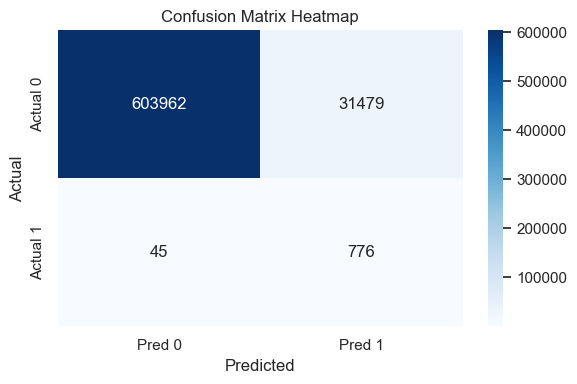

In [495]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred 0', 'Pred 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

In [497]:
y_proba = pipeline_l1.predict_proba(X_test)[:, 1]   # predicted probabilities for class 1

In [499]:
from sklearn.metrics import log_loss

logloss = log_loss(y_test, y_proba)
print("Log Loss:", logloss)

Log Loss: 0.1433045404256005


In [501]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_test, y_pred)
print("Cohen’s Kappa:", kappa)

Cohen’s Kappa: 0.04451763380429308


**Observation:**

Even with a log loss of 0.14, the cohen_kappa_score indicates that our model gives results that are not much better than random guessing given the imbalance.

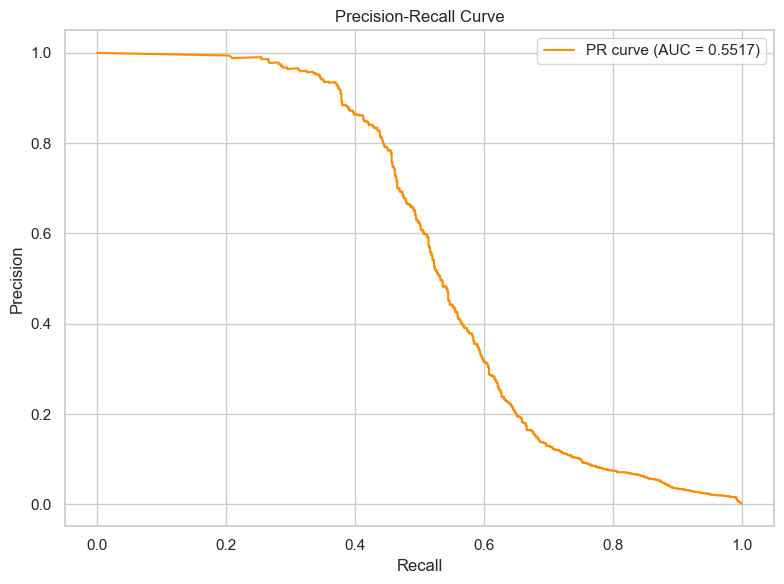

PR AUC (Average Precision): 0.5516539213373722


In [503]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall pairs for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute PR AUC (average precision)
pr_auc = average_precision_score(y_test, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("PR AUC (Average Precision):", pr_auc)

### Fine tuning

In [505]:
# Remove first element to align with thresholds
precision = precision[1:]  # variable from cell above
recall = recall[1:]

# Find index of first threshold where precision >= 0.05
target_precision = 0.05
idx = np.argmax(precision >= target_precision)

# Get best threshold
best_threshold = thresholds[idx]
print(f"Chosen threshold: {best_threshold:.4f}")
print(f"Precision at that threshold: {precision[idx]:.4f}")
print(f"Recall at that threshold: {recall[idx]:.4f}")

Chosen threshold: 0.7353
Precision at that threshold: 0.0500
Recall at that threshold: 0.8745


In [507]:
y_pred_base = (y_proba >= target_precision).astype(int)
print(classification_report(y_test, y_pred_base))
print("Cohen’s Kappa:", cohen_kappa_score(y_test, y_pred_base))

              precision    recall  f1-score   support

           0       1.00      0.72      0.84    635441
           1       0.00      1.00      0.01       821

    accuracy                           0.72    636262
   macro avg       0.50      0.86      0.42    636262
weighted avg       1.00      0.72      0.84    636262

Cohen’s Kappa: 0.006648357080127898


### **Observation:**

The results are even worst and the prediction more random. If we use the Logistic regression, we'll then keep our first model and use the top-K strategy to assess transaction flagged as frauds.


Or, we can try another method: the bagging models, more precisely, Random Forest.

## Bagging: Random Forest

In [126]:
from sklearn.ensemble import RandomForestClassifier

# New preprocessor (no StandardScaler for trees)
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical)
    ],
    remainder='passthrough'  # keep numeric features as is
)

# Pipeline with Random Forest
pipeline_rf = Pipeline([
    ('prep', preprocessor_rf),
    ('clf', RandomForestClassifier(
        class_weight='balanced',
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
        verbose = 1
    ))
])

# Fit
pipeline_rf.fit(X_train, y_train)

# Predict
y_pred_rf = pipeline_rf.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   58.3s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.2s finished


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635441
           1       0.95      0.81      0.88       821

    accuracy                           1.00    636262
   macro avg       0.98      0.91      0.94    636262
weighted avg       1.00      1.00      1.00    636262



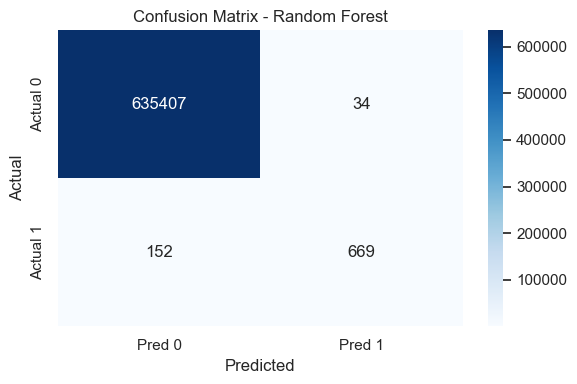

In [128]:
# Classification report
print(classification_report(y_test, y_pred_rf))

# Confusion matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.show()

In [136]:
# Get predicted probabilities for class 1
y_proba_rf = pipeline_rf.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.2s finished


In [303]:
# Log loss
print("Log Loss:", log_loss(y_test, y_proba_rf))

# Kappa
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred_rf))

# PR AUC (average precision)
print("PR AUC (Average Precision):", average_precision_score(y_test, y_proba_rf))

Log Loss: 0.0009657980312185579
Cohen's Kappa: 0.877807292814705
PR AUC (Average Precision): 0.962526057052841


### **Observations:**

Log Loss very low, Cohen's kappa high (model prediction results non-random) and Precision-Recall AUC very high ==> Very good model.

We'll try to get a better recall because it's better to be more suspicious about transaction than careless. The cost can be too high when you don't catch a fradulent transaction.

### Fine tuning the improve the recall

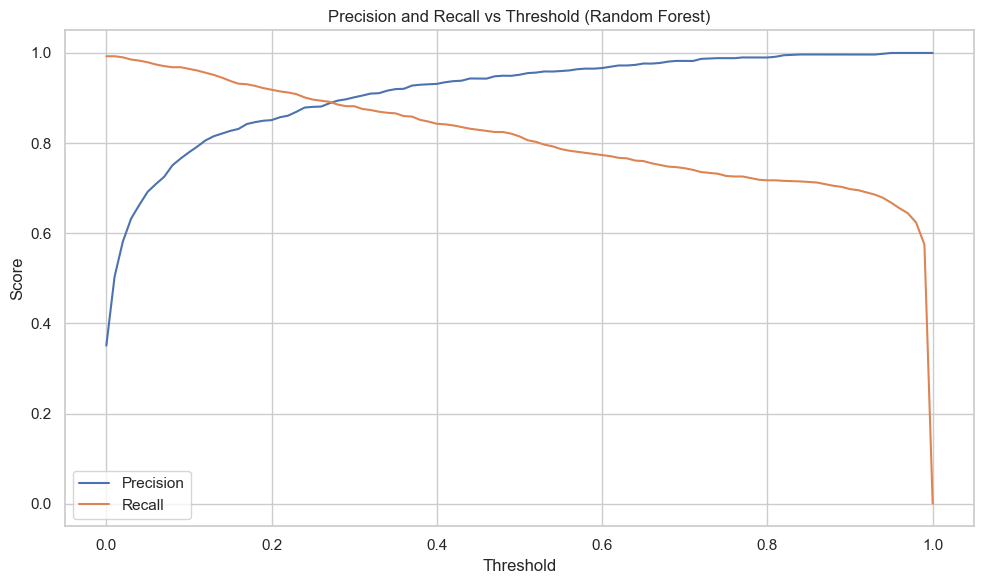

In [145]:
from sklearn.metrics import precision_recall_curve

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_proba_rf)

# Remove first element to align lengths
precision_rf = precision_rf[1:]
recall_rf = recall_rf[1:]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds_rf, precision_rf, label='Precision')
plt.plot(thresholds_rf, recall_rf, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold (Random Forest)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### **First approach to improve the recall**

In [147]:
# Threshold to improve the recall
target_recall = 0.90
idx = np.argmax(recall_rf >= target_recall)

if idx < len(thresholds_rf):
    best_threshold = thresholds_rf[idx]
    print(f"Threshold to reach recall ≥ {target_recall}: {best_threshold:.4f}")
    print(f"Precision at that threshold: {precision_rf[idx]:.4f}")
    print(f"Recall at that threshold: {recall_rf[idx]:.4f}")
else:
    print("No threshold found to reach target recall.")

Threshold to reach recall ≥ 0.9: 0.0000
Precision at that threshold: 0.3507
Recall at that threshold: 0.9927


#### **Second approach to improve the recall**

In [151]:
# Find all threshold where recall >= 0.90 and precision >= 0.80
valid_idxs = np.where((recall_rf >= 0.90) & (precision_rf >= 0.80))[0]

if len(valid_idxs) > 0:
    idx = valid_idxs[0]
    best_threshold = thresholds_rf[idx]
    print(f"Chosen threshold: {best_threshold:.4f}")
    print(f"Precision: {precision[idx]:.4f}")
    print(f"Recall: {recall[idx]:.4f}")
else:
    print("No threshold where recall ≥ 0.90 and precision ≥ 0.80")

Seuil choisi: 0.1200
Precision: 0.0013
Recall: 1.0000


In [475]:
y_pred_rf_tuned = (y_proba_rf >= best_threshold).astype(int)
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred_rf_tuned))

Cohen's Kappa: 0.8682781648184432


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635441
           1       0.79      0.96      0.87       821

    accuracy                           1.00    636262
   macro avg       0.90      0.98      0.93    636262
weighted avg       1.00      1.00      1.00    636262



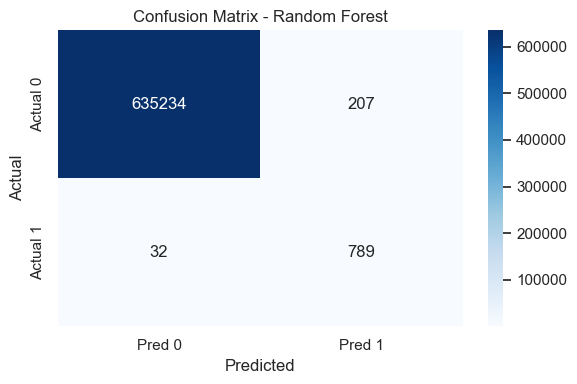

In [473]:
# Classification report
print(classification_report(y_test, y_pred_rf_tuned))

# Confusion matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_rf_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.show()

### **Observations:**

Our recall increases to 0.96 (we lost some degree of precision), but our kappa is still very good.
We'll keep that model and that threshold.

## Export the model

In [171]:
import joblib
from sklearn.preprocessing import FunctionTransformer

# function to create the balance differences for the sender and the receiver
from BalanceDifference import add_balance_diffs
balance_diff_adder = FunctionTransformer(add_balance_diffs, validate=False)

# Define your categorical variable list (example)
categorical = ["type"]

# Pipeline with balance differences + preprocessing + RF model
pipeline_rf_opt = Pipeline([
    ('add_diffs', balance_diff_adder),
    ('prep', preprocessor_rf),
    ('clf', RandomForestClassifier(
        class_weight='balanced',
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

# Train the model with the new function to create the balance differences 
pipeline_rf_opt.fit(X_train, y_train)

# Export model + threshold
model_package = {
    "model": pipeline_rf_opt,
    "threshold": 0.12
}

joblib.dump(model_package, "final_rf_model_with_threshold.pkl")

['final_rf_model_with_threshold.pkl']

## Test the results - Flagged as fraud

In [174]:
import pandas as pd
threshold = 0.12

# Predict probabilities
y_proba = pipeline_rf.predict_proba(X_test)[:, 1]  # probability of class 1 (fraud)

# Flag predictions using threshold
y_pred_flagged = (y_proba >= threshold).astype(int)

# Get indices of flagged frauds
flagged_indices = (y_pred_flagged == 1)

# Create a DataFrame to inspect
flagged_transactions = X_test[flagged_indices].copy()
flagged_transactions["proba_fraud"] = y_proba[flagged_indices]
flagged_transactions["true_label"] = y_test[flagged_indices].values

# Optional: sort by probability descending
flagged_transactions = flagged_transactions.sort_values(by="proba_fraud", ascending=False)

# Show top 10 flagged
flagged_transactions.head(10)

[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.2s finished


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,balanceDiffOrig,balanceDiffDest,proba_fraud,true_label
1186590,TRANSFER,190737.49,190737.49,0.0,0.00,0.00,190737.49,0.00,1.0,1
1030725,TRANSFER,114339.10,114339.10,0.0,0.00,0.00,114339.10,0.00,1.0,1
1456143,CASH_OUT,2873536.01,2873536.01,0.0,0.00,2873536.01,2873536.01,2873536.01,1.0,1
4372140,CASH_OUT,1868438.44,1868438.44,0.0,0.00,1868438.44,1868438.44,1868438.44,1.0,1
5186920,CASH_OUT,1742012.06,1742012.06,0.0,70881.61,1812893.67,1742012.06,1742012.06,1.0,1
6296750,TRANSFER,3150438.28,3150438.28,0.0,0.00,0.00,3150438.28,0.00,1.0,1
1030689,TRANSFER,4830219.15,4830219.15,0.0,0.00,0.00,4830219.15,0.00,1.0,1
5911183,TRANSFER,186375.38,186375.38,0.0,0.00,0.00,186375.38,0.00,1.0,1
6203409,TRANSFER,8286342.51,8286342.51,0.0,0.00,0.00,8286342.51,0.00,1.0,1
1506706,TRANSFER,343999.80,343999.80,0.0,0.00,0.00,343999.80,0.00,1.0,1


In [177]:
flagged_transactions.tail(10)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,balanceDiffOrig,balanceDiffDest,proba_fraud,true_label
5954402,CASH_OUT,27390.18,26560.00,0.0,73931.97,101322.15,26560.00,27390.18,0.12,0
2773120,CASH_OUT,40609.62,39732.00,0.0,65478.54,106088.16,39732.00,40609.62,0.12,0
373768,CASH_OUT,9429.74,8782.00,0.0,849305.76,858735.49,8782.00,9429.73,0.12,0
4777193,CASH_OUT,99032.20,97288.00,0.0,0.00,99032.20,97288.00,99032.20,0.12,0
435410,CASH_OUT,30473.54,30395.00,0.0,56505.50,86979.04,30395.00,30473.54,0.12,0
1030670,CASH_OUT,24412.07,24412.07,0.0,1564103.49,1588515.56,24412.07,24412.07,0.12,1
3747719,CASH_OUT,147371.78,4505.40,0.0,243981.15,391352.93,4505.40,147371.78,0.12,0
48118,TRANSFER,879328.96,869277.40,0.0,59672.00,16972.51,869277.40,-42699.49,0.12,0
6259434,CASH_OUT,93253.25,93253.25,0.0,186617.76,279871.01,93253.25,93253.25,0.12,1
1426628,CASH_OUT,184331.84,182225.54,0.0,202752.37,387084.21,182225.54,184331.84,0.12,0


---
The end